## Machine Learning on Materials classification

In this project, we classify three groups of functional materials -- ferroelectrics, anti-ferroelectrics and paraelectrics, based on the experimental parameters e.g. radius, (effective) valence, electronegativity, polarisability etc.</br>

### Import modules

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, f_classif, SelectFromModel

### Import original data
Data structure: 198 perovskite compounds and 21 features.

In [68]:
original_data = pd.read_csv("data/original-data.csv")
df = pd.DataFrame(original_data)
df.head()

,No.,compound,valence,RA(pm)Ⅻ,RB(pm)Ⅵ,RA/RB,polA,polB,polA-polB,negA,...,ZA,ZB,RA(ai),RB(ai),ZA/RA,ZB/RB,(ZA/RA)/(ZB/RB),(ZA/RA)+(ZB/RB),Y,C
0,1,"Ba(W,Cu)1/2 O3",2 6 2,175.0,80.5,2.17,1.55,0.29,1.26,1.01,...,2.9,5.15,1.75,0.81,1.66,6.40,0.26,8.05,F,1
1,2,"Sr(W,Cu)1/2 O3",2 6 2,158.0,80.5,1.96,0.86,0.29,0.57,1.00,...,2.9,5.15,1.58,0.81,1.84,6.40,0.29,8.23,F,1
2,3,"Ba(Cu1/3,Ta2/3) O3",2 2 5,175.0,81.0,2.16,1.55,0.34,1.21,1.01,...,2.9,4.97,1.75,0.81,1.66,6.13,0.27,7.79,F,1
3,4,"Ba(Cu1/3,Nb2/3) O3",2 2 5,175.0,81.0,2.16,1.55,0.27,1.28,1.01,...,2.9,3.97,1.75,0.81,1.66,4.90,0.34,6.55,F,1
4,5,"Sr(Cu1/3,Nb2/3) O3",2 2 5,158.0,81.0,1.95,0.86,0.27,0.59,1.00,...,2.9,3.97,1.58,0.81,1.84,4.90,0.37,6.73,F,1


### Quick analysis and visualization

In [69]:
df = df.drop(['No.', 'valence', 'NegA(Bau)', 'NegB(Bau)', 'Neg(B-A)', 'RA(ai)', 'RB(ai)'], axis=1)
df.describe()

,RA(pm)Ⅻ,RB(pm)Ⅵ,RA/RB,polA,polB,polA-polB,negA,negB,negB-negA,ZA,ZB,ZA/RA,ZB/RB,(ZA/RA)/(ZB/RB),(ZA/RA)+(ZB/RB),C
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,162.540202,82.963990,1.973232,1.634495,0.399848,1.235505,1.156970,1.665808,0.509394,5.866263,4.636313,3.616717,5.614646,0.677475,9.230101,0.525253
std,10.843422,8.167906,0.195362,0.647761,0.192785,0.688655,0.117235,0.131821,0.181960,2.451801,1.186684,1.499966,1.393249,0.309587,2.049360,0.500628
min,132.000000,67.000000,1.410000,0.180000,0.140000,-0.300000,0.900000,1.320000,0.080000,2.200000,3.000000,1.240000,2.750000,0.190000,4.410000,0.000000
25%,158.000000,78.000000,1.852500,1.090000,0.280000,0.622500,1.010000,1.580000,0.390000,2.900000,3.600000,1.840000,4.570000,0.385000,7.910000,0.000000
50%,163.000000,81.125000,1.980000,2.000000,0.360000,1.460000,1.240000,1.660000,0.490000,7.300000,4.340000,4.410000,5.360000,0.690000,9.555000,1.000000
75%,163.000000,86.000000,2.110000,2.000000,0.467500,1.680000,1.240000,1.770000,0.617500,8.100000,5.130000,4.970000,6.407500,0.940000,10.565000,1.000000
max,184.000000,118.000000,2.480000,3.130000,1.250000,2.900000,1.400000,1.980000,0.980000,8.900000,8.900000,6.050000,9.110000,1.310000,14.080000,1.000000


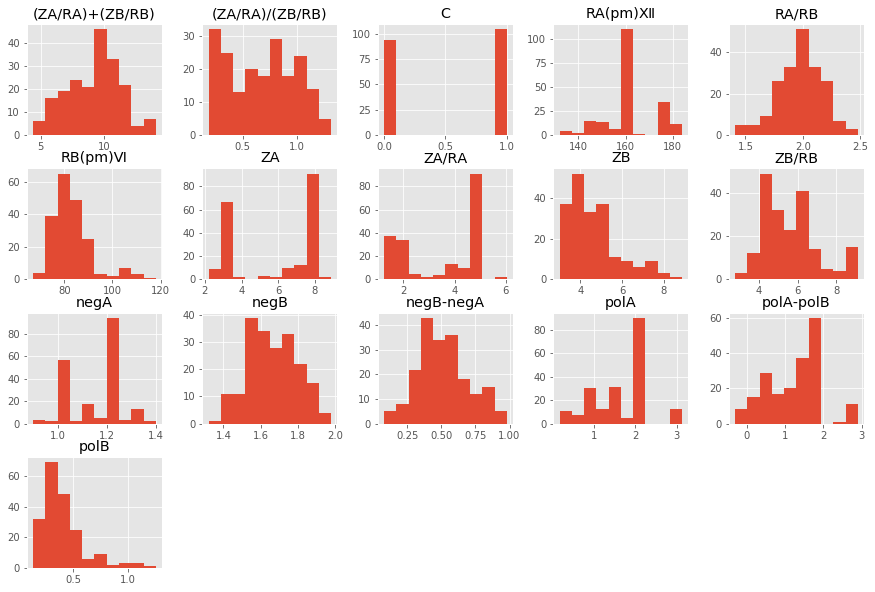

In [70]:
plt.style.use('ggplot')
_ = df.hist(figsize=(15,10), layout=(4,5))

### Data preprocessing and feature selection
Use ExtraTreesClassifier to check the importance of the features.
We can select the features based on the importance.

Feature ranking:
 1. feature 13 : polA-polB (0.105802)
 2. feature 12 : polB (0.099911)
 3. feature  9 : ZB/RB (0.095360)
 4. feature  5 : negB (0.088476)
 5. feature  7 : ZB (0.087314)
 6. feature 10 : (ZA/RA)/(ZB/RB) (0.079645)
 7. feature  3 : negB-negA (0.073333)
 8. feature  6 : ZA (0.068456)
 9. feature  8 : ZA/RA (0.066518)
10. feature  1 : RB(pm)Ⅵ (0.059325)
11. feature 11 : polA (0.056934)
12. feature  2 : RA/RB (0.056509)
13. feature  0 : RA(pm)Ⅻ (0.032836)
14. feature  4 : negA (0.029581)


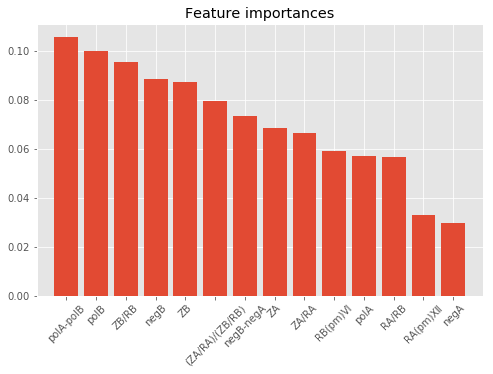

In [111]:
volumns = ['RA(pm)Ⅻ','RB(pm)Ⅵ','RA/RB','negB-negA',
           'negA','negB',
           'ZA','ZB','ZA/RA','ZB/RB',
           '(ZA/RA)/(ZB/RB)','polA','polB','polA-polB']
X = preprocessing.scale(np.array(df.loc[:,volumns]))
Y = np.array(df['Y'])
selector = ExtraTreesClassifier(n_estimators=100,random_state=0).fit(X, Y)

importances = selector.feature_importances_
indices = np.argsort(importances)[::-1]
volumns_reorder = []
print("Feature ranking:")
for f in range(X.shape[1]):
    volumns_reorder.append(volumns[indices[f]])
    print("%2d. feature %2d : %s (%f)" % (f + 1, indices[f], volumns[indices[f]], importances[indices[f]]))

plt.style.use('ggplot')
plt.figure(figsize=(8, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), volumns_reorder, rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()


Feature ranking:
 1. feature  9 : ZB/RB (0.658777)
 2. feature  8 : ZA/RA (0.529153)
 3. feature  0 : RA(pm)Ⅻ (0.354691)
 4. feature 12 : polB (0.112846)
 5. feature 11 : polA (0.000000)
 6. feature 10 : (ZA/RA)/(ZB/RB) (0.000000)
 7. feature  6 : ZA (0.000000)
 8. feature  3 : negB-negA (0.000000)
 9. feature  5 : negB (-0.054660)
10. feature 13 : polA-polB (-0.121397)
11. feature  4 : negA (-0.159135)
12. feature  1 : RB(pm)Ⅵ (-0.351074)
13. feature  7 : ZB (-0.430916)
14. feature  2 : RA/RB (-0.497608)


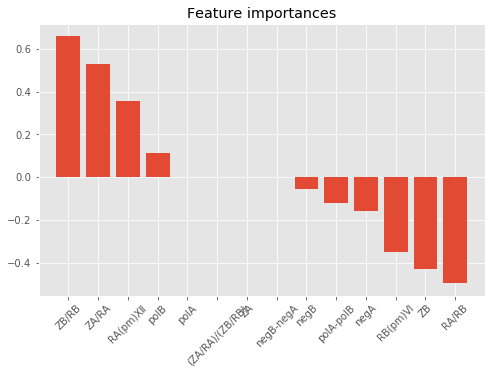

In [110]:
from sklearn.svm import LinearSVC


volumns = ['RA(pm)Ⅻ','RB(pm)Ⅵ','RA/RB','negB-negA',
           'negA','negB',
           'ZA','ZB','ZA/RA','ZB/RB',
           '(ZA/RA)/(ZB/RB)','polA','polB','polA-polB']
X = preprocessing.scale(np.array(df.loc[:,volumns]))
Y = np.array(df['Y'])

selector = LinearSVC(penalty='l1',random_state=0, dual=False).fit(X, Y)

importances = selector.coef_[0]
indices = np.argsort(importances)[::-1]

volumns_reorder = []
print("Feature ranking:")
for f in range(X.shape[1]):
    volumns_reorder.append(volumns[indices[f]])
    print("%2d. feature %2d : %s (%f)" % (f + 1, indices[f], volumns[indices[f]], importances[indices[f]]))

plt.style.use('ggplot')
plt.figure(figsize=(8, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), volumns_reorder, rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()


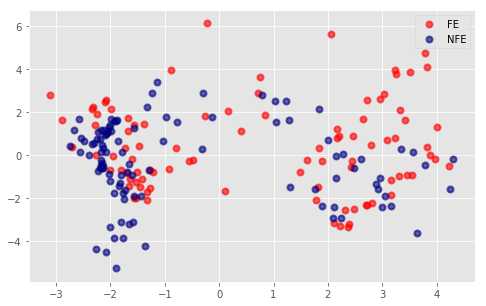

In [77]:
## Plot data from dimensionality reduction

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
Y = np.array(df['C'])

plt.figure(figsize=(8, 5))
colors = ['red', 'navy']
target_names = ['FE', 'NFE']
lw = 2
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.6, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

## PCA is not able to separate data.

### Results from different classifiers

#### Case 1: Two labels

In [94]:
## Split data into 80/20 in a stratified way

from collections import Counter

volumns = ['RA(pm)Ⅻ','RB(pm)Ⅵ','RA/RB','negB-negA',
           'negA','negB',
           'ZA','ZB','ZA/RA','ZB/RB',
           '(ZA/RA)/(ZB/RB)','polA','polB','polA-polB']
X = preprocessing.scale(np.array(df.loc[:,volumns]))
Y1 = np.array(df['C'])

X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.2, random_state=0, stratify=Y1)
#print (Counter(y_train), Counter(y_test))

In [99]:
## Logistic regression

from sklearn import linear_model

logR = linear_model.LogisticRegression()
logR.fit(X_train, y_train)
#logR.score(X_train, y_train)
logR.score(X_test, y_test)

0.65000000000000002

In [ ]:
clfs = dict(KNN=neighbors.KNeighborsClassifier(10),
        SVM=svm.SVC(kernel='rbf',C=5),
        Decision_Tree=DecisionTreeClassifier(max_depth=None),
        Random_Forest=RandomForestClassifier(n_estimators=100, random_state=0),
        Extra_Trees=ExtraTreesClassifier(n_estimators=100,random_state=0),
        Ada_Boost=AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=100))

for idx, clf in enumerate(clfs.values()):
    print('%15s : %f'%(list(clfs.keys())[idx], clf.fit(X_train, y_train).score(X_test, y_test)))
#    y_pred = clf.predict(X_test)
#    print(clf.score(X_test, y_test))
#y_test, y_pred

Cross validation prodictions

In [25]:
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

#for clf in clfs:
for idx, clf in enumerate(clfs.values()):
    y_pred = cross_val_predict(clf, X, Y1, cv=10)
    print('%15s : %f'%(list(clfs.keys())[idx], metrics.accuracy_score(Y1, y_pred)))
#scores = cross_val_score(clf, X, Y, cv=10)
#scores

  Decision_Tree : 0.681818
    Extra_Trees : 0.676768
            KNN : 0.616162
            SVM : 0.661616
      Ada_Boost : 0.631313
  Random_Forest : 0.691919


Result analysis

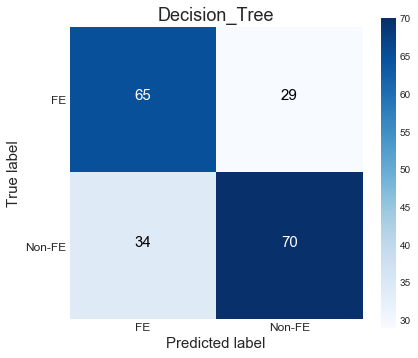

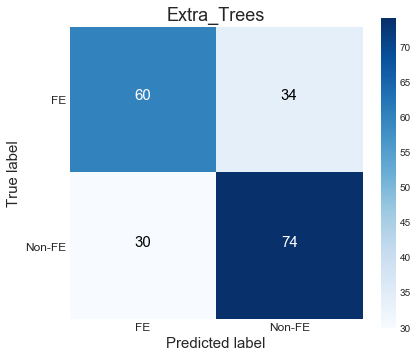

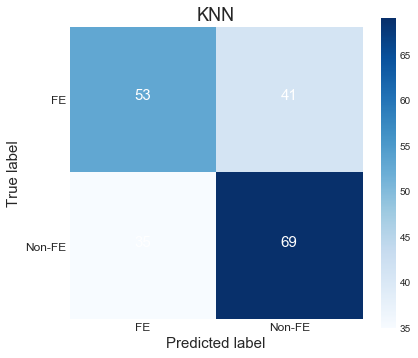

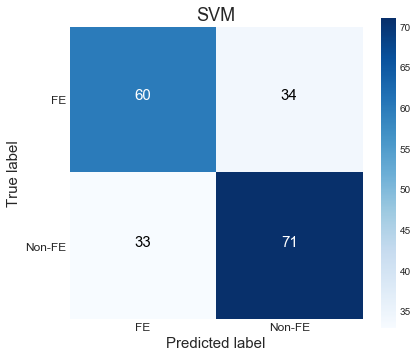

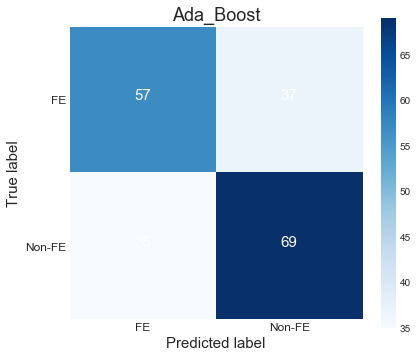

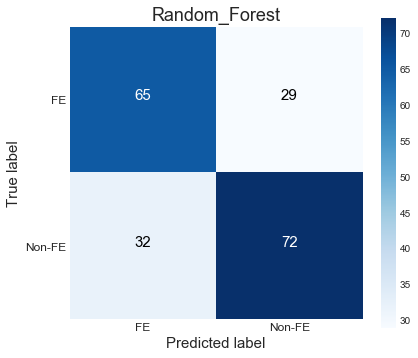

In [30]:
#clf = RandomForestClassifier(n_estimators=100, random_state=0)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.style.use('seaborn-dark')
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

#    if normalize:
#        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

#    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], fontsize=15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)


for idx, clf in enumerate(clfs.values()):
    y_pred = cross_val_predict(clf, X, Y1, cv=10)
    cnf_matrix = confusion_matrix(Y1, y_pred)
    class_names = np.array(['FE','Non-FE'])
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title=list(clfs.keys())[idx],
                          cmap=plt.cm.Blues)

#### Case 2: Three labels

In [21]:
Y2 = np.array(df['Y'])
X_train, X_test, y_train, y_test = train_test_split(X, Y2, test_size=0.1, random_state=0)

for idx, clf in enumerate(clfs.values()):
    print('%15s : %f'%(list(clfs.keys())[idx], clf.fit(X_train, y_train).score(X_test, y_test)))

  Decision_Tree : 0.750000
    Extra_Trees : 0.800000
            KNN : 0.750000
            SVM : 0.800000
      Ada_Boost : 0.800000
  Random_Forest : 0.850000


Cross validation prodictions

In [22]:
for idx, clf in enumerate(clfs.values()):
    y_pred = cross_val_predict(clf, X, Y2, cv=10)
    print('%15s : %f'%(list(clfs.keys())[idx], metrics.accuracy_score(Y2, y_pred)))

  Decision_Tree : 0.601010
    Extra_Trees : 0.722222
            KNN : 0.585859
            SVM : 0.712121
      Ada_Boost : 0.712121
  Random_Forest : 0.737374


Result analysis

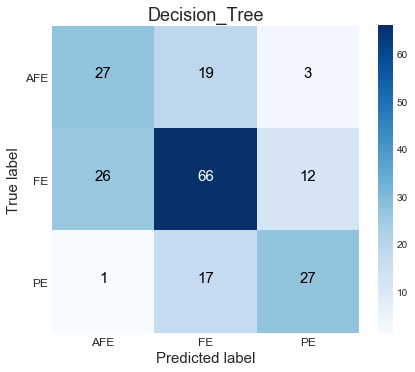

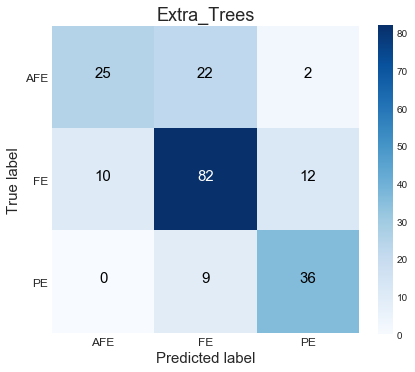

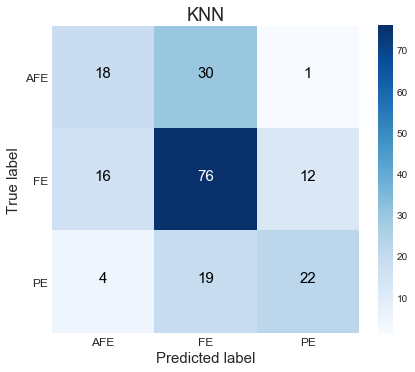

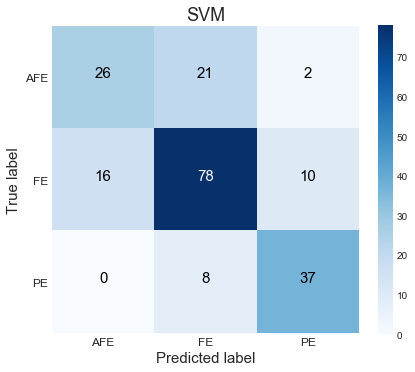

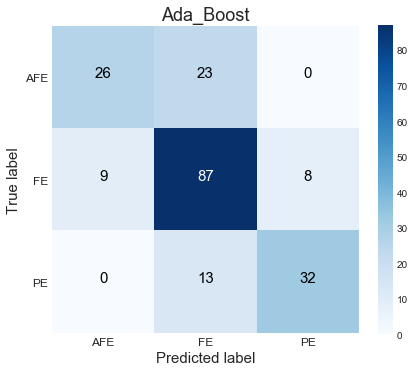

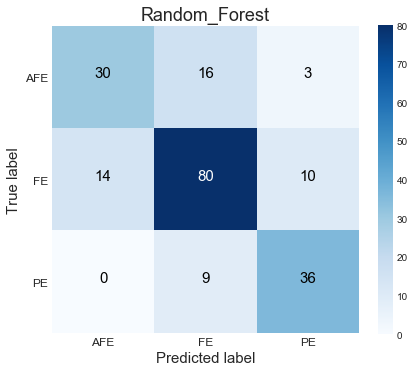

In [23]:
for idx, clf in enumerate(clfs.values()):
    y_pred = cross_val_predict(clf, X, Y2, cv=10)
    cnf_matrix = confusion_matrix(Y2, y_pred)
    class_names = np.array(['AFE','FE','PE'])
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title=list(clfs.keys())[idx],
                          cmap=plt.cm.Blues)